# Multivariate Time Series Regression 

이성주 (c) 2018

seongjoo@codebasic.io

In [2]:
import os.path
from datetime import datetime

import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
from deepy.timeseries import time_step_seq

ModuleNotFoundError: No module named 'deepy'

주중 미국 대사관 북경 대기오염 측정 자료

[Beijing PM2.5 Data Set (UCI-ML)](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

In [ ]:
data = pd.read_csv(
    '../data/uci-ml/beijing-pm25.csv',
    index_col=0,
    parse_dates=[['year', 'month', 'daxgy', 'hour']],
    date_parser=lambda dt_str: datetime.strptime(dt_str, '%Y %m %d %H')
)

data.index.name = 'datetime'
time_index = data.index
data = data.drop(columns='No')
data[:5]

누락된 값 처리

In [ ]:
data = data.fillna(data['pm2.5'].mean())

In [ ]:
data.shape

In [ ]:
axes = data.plot(subplots=True, figsize=(10, 10))

$$ x^{t-1}_1, x^{t-1}_2, ... , x^{t-1}_n \rightarrow y^{t} $$

One Hot Encoding

In [1]:
data = pd.get_dummies(data)
data[:5]
# CNN은 안 먹힘. CNN은 features 간에 서로 영향을 주고 받는다는 건데, 이건 순서가 어떻든 상관없음.
# 이 데이터는 시간 흐름이 중요한 것임.

NameError: name 'pd' is not defined

스케일 조정

In [8]:
scaler = MinMaxScaler()

In [9]:
data = scaler.fit_transform(data)

시계열 데이터를 지도학습의 입력으로 사용하기 위한 형상 형성

X: ..., X(t-1), X(t)  
Y: X(t+1), X(t+2), ...

In [10]:
X, Y = time_step_seq(data, look_back=0, look_forward=1)

In [11]:
X.shape

(43823, 1, 11)

In [12]:
Y.shape

(43823, 1, 11)

In [13]:
y = Y[:, 0, 0]

In [14]:
y

array([ 0.09920847,  0.09920847,  0.09920847, ...,  0.01006036,
        0.00804829,  0.01207243])

Train/Test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [16]:
X_train.shape

(32867, 1, 11)

In [17]:
DataFrame(X_train[:, -1, :])[:3]

,0,1,2,3,4,5,6,7,8,9,10
0,0.099208,0.279412,0.131148,0.545455,0.002290,0.0,0.0,0.0,1.0,0.0,0.0
1,0.099208,0.279412,0.114754,0.527273,0.007639,0.0,0.0,0.0,1.0,0.0,0.0
2,0.099208,0.279412,0.131148,0.509091,0.010698,0.0,0.0,0.0,1.0,0.0,0.0


모델 구성

In [18]:
model_filepath = '../outputs/mv-rnn-ts1.h5'
train_history_filepath = '../outputs/train-history-mv-rnn-ts1.csv'

In [19]:
time_steps = X.shape[1]
data_dim = X_train.shape[-1]

In [20]:
if os.path.exists(model_filepath):
    model = load_model(model_filepath)
else:    
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_steps, data_dim)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # train
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=72, shuffle=False, validation_split=0.2)
    # save model
    model.save(model_filepath)
    train_result = DataFrame(history.history)
    # save train results
    train_result.to_csv(train_history_filepath, encoding='utf-8')

Train on 26293 samples, validate on 6574 samples
Epoch 1/50
26293/26293 [==============================] - 2s 61us/step - loss: 0.0379 - val_loss: 0.0934
Epoch 2/50
26293/26293 [==============================] - 1s 57us/step - loss: 0.0190 - val_loss: 0.0489
Epoch 3/50
26293/26293 [==============================] - 1s 57us/step - loss: 0.0148 - val_loss: 0.0352
Epoch 4/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0139 - val_loss: 0.0247
Epoch 5/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0136 - val_loss: 0.0202
Epoch 6/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0134 - val_loss: 0.0188
Epoch 7/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0134 - val_loss: 0.0195
Epoch 8/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0134 - val_loss: 0.0173
Epoch 9/50
26293/26293 [==============================] - 1s 56us/step - loss: 0.0134 - val_loss: 0.0177
Epoch 

In [21]:
if os.path.exists(train_history_filepath):
    train_result = pd.read_csv(train_history_filepath)

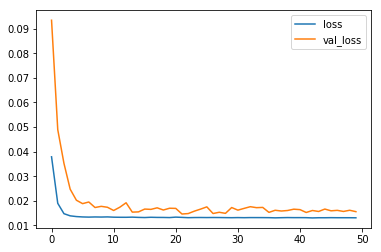

In [22]:
train_result[['loss', 'val_loss']].plot()

In [23]:
y_pred_train = model.predict(X_train)

In [24]:
train_score = r2_score(y_train, y_pred_train)
train_score

0.90750741054958128

In [25]:
y_pred_test = model.predict(X_test)

In [26]:
test_score = r2_score(y_test, y_pred_test)
test_score

0.93237214897655485

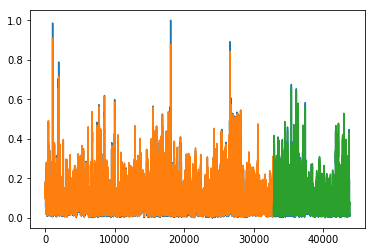

In [27]:
train_size = len(X_train)
xs_train = np.arange(train_size)
xs_test = np.arange(train_size, len(y))
plt.plot(y)
plt.plot(xs_train, y_pred_train)
plt.plot(xs_test, y_pred_test)

## Stacked LSTM 

In [28]:
model_filepath = '../outputs/mv-rnn-stacked-ts1.h5'
train_history_filepath = '../outputs/train-history-mv-rnn-stacked-ts1.csv'

In [29]:
if os.path.exists(model_filepath):
    model = load_model(model_filepath)
else:    
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, data_dim)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # train
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=72, shuffle=False, validation_split=0.2)
    # save model
    model.save(model_filepath)
    train_result = DataFrame(history.history)
    # save train results
    train_result.to_csv(train_history_filepath, encoding='utf-8')

Train on 26293 samples, validate on 6574 samples
Epoch 1/50
26293/26293 [==============================] - 3s 112us/step - loss: 0.0412 - val_loss: 0.0540
Epoch 2/50
26293/26293 [==============================] - 3s 99us/step - loss: 0.0149 - val_loss: 0.0257
Epoch 3/50
26293/26293 [==============================] - 3s 101us/step - loss: 0.0139 - val_loss: 0.0208
Epoch 4/50
26293/26293 [==============================] - 3s 100us/step - loss: 0.0138 - val_loss: 0.0197
Epoch 5/50
26293/26293 [==============================] - 3s 99us/step - loss: 0.0136 - val_loss: 0.0179
Epoch 6/50
26293/26293 [==============================] - 3s 100us/step - loss: 0.0135 - val_loss: 0.0178
Epoch 7/50
26293/26293 [==============================] - 3s 100us/step - loss: 0.0134 - val_loss: 0.0153
Epoch 8/50
26293/26293 [==============================] - 3s 100us/step - loss: 0.0134 - val_loss: 0.0149
Epoch 9/50
26293/26293 [==============================] - 3s 100us/step - loss: 0.0136 - val_loss: 0.0153

In [30]:
if os.path.exists(train_history_filepath):
    train_result = pd.read_csv(train_history_filepath)

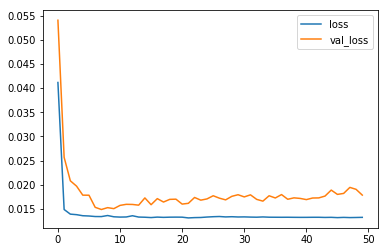

In [31]:
train_result[['loss', 'val_loss']].plot()

In [32]:
y_pred_train = model.predict(X_train)

In [33]:
train_score = r2_score(y_train, y_pred_train)
train_score

0.89374200516925206

In [34]:
y_pred_test = model.predict(X_test)

In [35]:
test_score = r2_score(y_test, y_pred_test)
test_score

0.92195847670870434

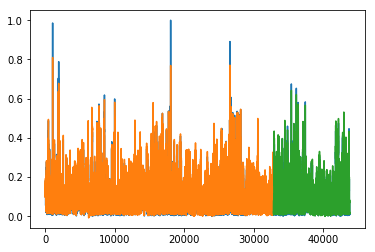

In [36]:
train_size = len(X_train)
xs_train = np.arange(train_size)
xs_test = np.arange(train_size, len(y))
plt.plot(y)
plt.plot(xs_train, y_pred_train)
plt.plot(xs_test, y_pred_test)

## Multi Lag Prediction

..., x(t-1), x(t) --> y(t+1)

In [37]:
X, Y = time_step_seq(data, look_back=1, look_forward=1)

In [38]:
X.shape

(43822, 2, 11)

In [39]:
Y.shape

(43822, 1, 11)

In [40]:
y = Y[:, 0, 0]

Train/Test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [42]:
X_train.shape

(32866, 2, 11)

모델 구성

In [43]:
model_filepath = '../outputs/mv-rnn-input_2_ouput_1.h5'
train_history_filepath = '../outputs/train-history-mv-rnn-input_2_output_1.csv'

In [44]:
time_steps = X.shape[1]
data_dim = X.shape[-1]

In [45]:
if os.path.exists(model_filepath):
    model = load_model(model_filepath)
else:    
    model = Sequential()
    model.add(LSTM(50, input_shape=(time_steps, data_dim)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # train
    history = model.fit(
        X_train, y_train, epochs=50, batch_size=72, shuffle=False, validation_split=0.2)
    # save model
    model.save(model_filepath)
    train_result = DataFrame(history.history)
    # save train results
    train_result.to_csv(train_history_filepath, encoding='utf-8')

Train on 26292 samples, validate on 6574 samples
Epoch 1/50
26292/26292 [==============================] - 2s 90us/step - loss: 0.0322 - val_loss: 0.0564
Epoch 2/50
26292/26292 [==============================] - 2s 80us/step - loss: 0.0176 - val_loss: 0.0243
Epoch 3/50
26292/26292 [==============================] - 2s 80us/step - loss: 0.0160 - val_loss: 0.0197
Epoch 4/50
26292/26292 [==============================] - 2s 80us/step - loss: 0.0157 - val_loss: 0.0181
Epoch 5/50
26292/26292 [==============================] - 2s 81us/step - loss: 0.0152 - val_loss: 0.0193
Epoch 6/50
26292/26292 [==============================] - 2s 80us/step - loss: 0.0148 - val_loss: 0.0175
Epoch 7/50
26292/26292 [==============================] - 2s 79us/step - loss: 0.0142 - val_loss: 0.0163
Epoch 8/50
26292/26292 [==============================] - 2s 80us/step - loss: 0.0136 - val_loss: 0.0149
Epoch 9/50
26292/26292 [==============================] - 2s 79us/step - loss: 0.0135 - val_loss: 0.0142
Epoch 

In [46]:
if os.path.exists(train_history_filepath):
    train_result = pd.read_csv(train_history_filepath)

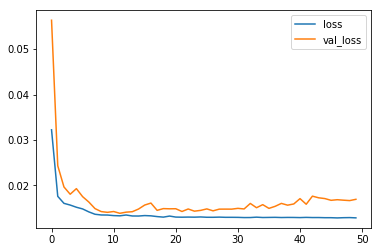

In [47]:
train_result[['loss', 'val_loss']].plot()

In [48]:
y_pred_train = model.predict(X_train)

In [49]:
train_score = r2_score(y_train, y_pred_train)
train_score

0.89880641374582737

In [50]:
y_pred_test = model.predict(X_test)

In [51]:
test_score = r2_score(y_test, y_pred_test)
test_score

0.92762303407350521

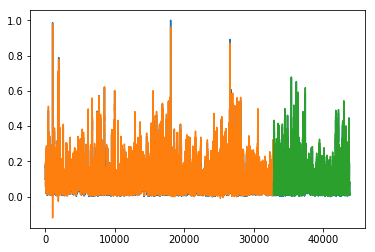

In [52]:
train_size = len(X_train)
xs_train = np.arange(train_size)
xs_test = np.arange(train_size, len(y))
plt.plot(y)
plt.plot(xs_train, y_pred_train)
plt.plot(xs_test, y_pred_test)